<a href="https://colab.research.google.com/github/Kustikk/string_art_colab/blob/master/Computational_Thread_Art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## `imports` (don't read, just run)

In [24]:
import os, sys
import shutil

!wget https://github.com/callummcdougall/computational-thread-art-v2/archive/refs/heads/main.zip
!unzip /content/main.zip 'computational-thread-art-v2-main/*'
os.remove("/content/main.zip")
for x in os.listdir("computational-thread-art-v2-main"):
    shutil.move(f"computational-thread-art-v2-main/{x}", x)
os.rmdir("computational-thread-art-v2-main")

!apt-get install -y python3-dev libcairo2-dev
!pip install -r requirements.txt

--2025-01-04 08:15:46--  https://github.com/callummcdougall/computational-thread-art-v2/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/callummcdougall/computational-thread-art-v2/zip/refs/heads/main [following]
--2025-01-04 08:15:46--  https://codeload.github.com/callummcdougall/computational-thread-art-v2/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [   <=>              ]   1.95M  4.54MB/s    in 0.4s    

2025-01-04 08:15:47 (4.54 MB/s) - ‘main.zip’ saved [2044744]

Archive:  /content/main.zip
ba81966fb0f40d2a10e39622f9dc23405250788b
repla

Error: Destination path 'images/images' already exists

In [25]:
from coordinates import *
from imageColor import *
from misc import *

# Params

Here's where you can set the parameters for the model. Some explanation:

* `name` is the model name (what it'll be saved as).
* `x` is the number of pixels in the x-direction we scale the image to. I've found about 600-900 to be sufficient for an image with an aspect ratio of 1:1 (images which are longer horizontally will need a larger `x` value). Increasing `x` past this range will improve the image, but lead to diminishing returns.
* `n_nodes` is the number of nodes around the perimeter of the image, for the lines to connect.
* `filename` is the name of the image (you should upload this in local storage).
* `w_filename` is the importance weighting (optional, in general we recommend you don't use it). If supplied, this should be an image with the same size as the previous image, but it's monochrome. Black represents an importance weighting of 1, and white is 0 (so you want more important features to be black).
* `palette` is a dictionary of named colors. You'll be able to choose this. I recommend always using black and white, as well as between 1 and 4 additional colors depending on the image. Note that failure to choose a palette that captures the full range of the image will result in the dithering algorithm performing poorly and creating a "broken image" - this is one reason why I usually stick to images with a single color scheme.
* `n_lines_per_color` is a list of the number of lines you'll have for each color, in the same order as the dict. You can set these arbitrarily at first (e.g. zero for all colors), because later you'll get some output which will help you decide how many lines to use.
* `shape` can be either `"Rectangle"` or `"Ellipse"`. This determines the shape of the final output.
* `n_random_lines` is the number of random lines you generate for each one you choose. Beyond 200, this doesn't really improve the image much.
* `darkness` is the float value that gets subtracted from each pixel when you draw a line through it. It should be larger if you use a larger image. I've usually found values between 0.1 and 0.2 to work well, if other parameters are in their standard ranges. Smaller values of `darkness` are compatible with a larger total number of lines (because the algorithm will require more lines to cover areas of the same intensity).
* `blur_rad` allows you to blur the single-color images you get. This can slightly improve performance, but honestly it doesn't matter that much. I usually leave it at 4.
* `group_orders` is a string representing the order of lines you place on the image (e.g. the one below indicates white, dark blue, light blue, ..., black). If a letter appears more than once, it means we do a fraction of the lines in that group before moving on to a different color. I usually set these values by starting with the string `"123...123...123...123..."` (where 1 is the lightest color, usually white, and the order is from lightest to darkest, and there are 4 groups total), then adjusting this based on the output (e.g. if one color isn't visible enough then I'll move more of it to the end of the string, so it ends up on top).
* `line_width_multiplier` controls the appearance of the SVG output you get at the end (it makes the lines thicker). This is useful when you're using a very large `x`.

Of these parameters, the most important ones (i.e. the ones you shouldn't just leave at their default values) are:

* `name`, `x` and `filename` - these should be set to the appropriate values based on the image you choose.
* `palette`, `n_lines_per_color`, `group_orders` - these should be set based on what colors you want to use, and in what densities. As mentioned, we'll show you below how to choose `n_lines_per_color`.
* `shape`, i.e. whether you want it to be a rectangle or ellipse.

In [26]:
PARAMS = dict(
    name = "stag",
    x = 1200,
    n_nodes = 500,
    filename = "stag.jpg",
    w_filename = None,
    palette = dict(
        white = [255, 255, 255],
        light_blue = [0, 215, 225],
        mid_blue = [0, 120, 240],
        dark_blue = [0, 0, 120],
        black = [0, 0, 0]
    ),
    n_lines_per_color = [900,  700,  450, 2200, 4800],
    shape = "Rectangle",
    n_random_lines = 150,
    darkness = 0.18,
    blur_rad = 4,
    group_orders = "wdlbwdmlbwdmlbmb",
    line_width_multiplier = 1.5,
)

# Floyd-Steinberg dithering & choosing a palette

Once you've chosen your params and run the code below, you should run the cell below. This takes a few seconds, because it involves building a "pixels dictionary" which maps pairs of nodes `(N1, N2)` to the PyTorch tensor of coordinates representing the line that goes through them. Storing this as a large dictionary is a large computational speedup relative to computing this line each time we generate a set of random lines during the algorithm.

In [ ]:
args = ThreadArtColorParams(**PARAMS)

Building pixels dict:  99%|█████████▉| 90460/91012 [00:18<00:00, 5839.12it/s]

Next, you can run the following cell to create an `Img` object, which contains the image data as well as dithered versions. It takes a few seconds, because dithering isn't an efficient process (you have to go pixel by pixel, row by row).

In [ ]:
MyImg = Img(**args.img_dict)

Now it comes to the color decomposition. Running the cell below will display the dithered versions of the image, and print out a recommendation for how many lines of each color you should use, for some given total number of lines. My recommendation for number of lines:

* If you're just making a piece digitally, values between 12000 - 24000 usually look best.
* For physical pieces, if they're circular & on bike wheels then I usually go with around 7500 lines, and if they're larger then I'll scale up by the square root of the ratio of the area of the shape I'm using.

You can change the value of `args.n_lines_per_color` manually at this point (as well as things like `args.group_orders`) if you like.

In [ ]:
MyImg.decompose_image(10000)
# args.n_lines_per_color = [1301, 846, 237, 2643, 4973]

In [ ]:
MyImg.display_output(height=500, width=800)

# Generating an image

Finally, you can run the code below to generate the full thread art image. It will take longer to run than the earlier code (should still be under a minute in most cases).

In [ ]:
line_dict = create_canvas(MyImg, args)

Color white,      line  900/900  done.
Color light_blue, line  700/700  done.
Color mid_blue,   line  450/450  done.
Color dark_blue,  line 2200/2200 done.
Color black,      line 4800/4800 done.
total time = 95.72


You can use the code below to generate the visualisation and save it. You can leave most of the extra arguments as default, but I'll explain a few of them here regardless:

* `background_color` - this is the background color (RGB values between 0 and 255) which the generated image will be set on.
* `fraction` - if you change this to e.g. (0, 0.8) then it'll only show the first 80% of threads (useful if you're trying to decide whether you can get away with using less).
* `show_individual_colors` - when this is true, you generate an image for each sub-color, like the breakdown of the tiger which you can see on my [blog post](https://www.perfectlynormal.co.uk/blog-computational-thread-art).

In [ ]:
paint_canvas(
    line_dict,
    MyImg,
    args,
    mode="svg",
    rand_perm=0.0025,
    fraction=(0, 1),
    filename_override=None,
    background_color=(0, 0, 0),
    show_individual_colors=False,
)

Saving to 'outputs/stag_02.svg'


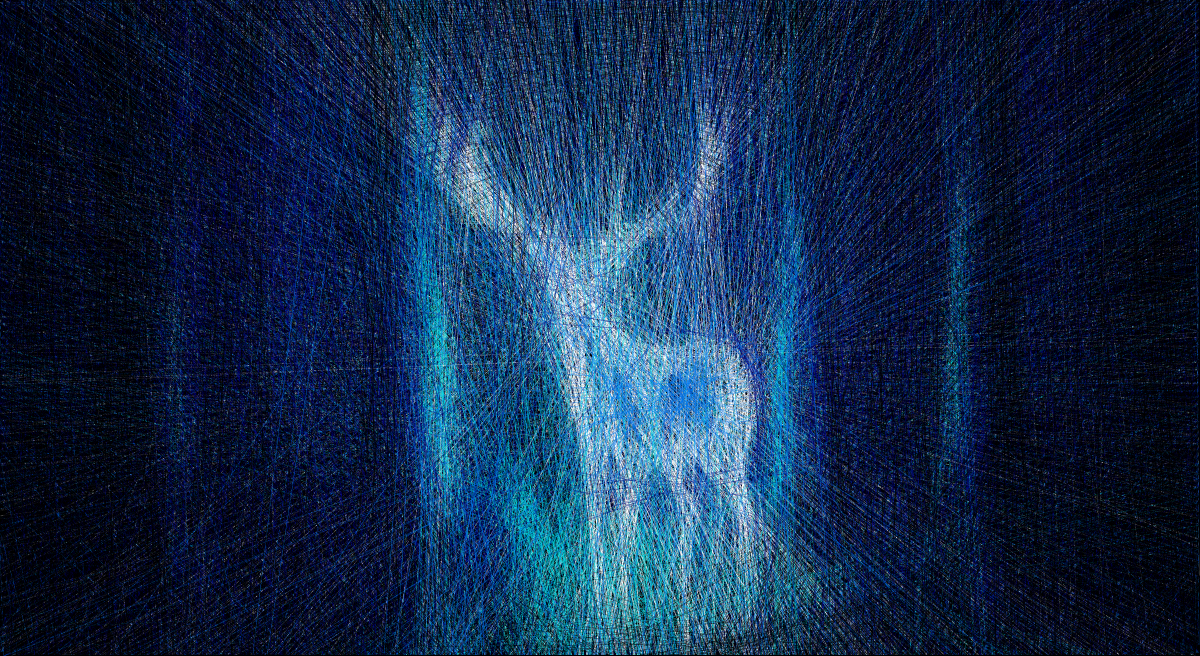

In [ ]:
with open('outputs/stag_01.svg', 'r') as f:
    display(SVG(f.read()))

## Animations

You can create an animation below. It takes a few seconds to generate the animation, and it also takes up a lot of storage space (there's probably a much more efficent way to do this).

In [ ]:
x_output = 2000
gif_duration = 125
n_frames_total = 100
line_width_multiplier = 0.3

render_animation(
    MyImg,
    args,
    line_dict,
    x_output,
    gif_duration,
    n_frames_total,
    background_color=(255, 239, 194), # brown
)

Generated output pixels dict.
Created frames list.
Saved animation as: 'animations/animated-stag.gif'


## Creating a physical piece

When you like an image, if you want to make it physically, you can run the code below to generate a pdf of instructions. This is how I create my images (I stick labels around the outside of the frame, one every ten picture hooks, and I use the numbers in the PDF to efficiently loop threads around the hooks). Note that I use picture hooks as my nodes, meaning every hook represents two different nodes (one for each side of the hook). The `-0` and `-1` at the end of each line in the PDF represents the side of the hook. They're numbered so that, if you wanted to trace all the threads around the nodes from the bottom node on the right side and moving anticlockwise around the rectangle, the order would be:

<code>0 0 <span style="color:dodgerblue;">0</span></code> (down-facing edge of the first hook)
<br><code>0 0 <span style="color:dodgerblue;">1</span></code> (up-facing edge of the first hook)
<br><code>0 1 <span style="color:dodgerblue;">0</span></code>
<br><code>0 1 <span style="color:dodgerblue;">0</span></code> (second hook)
<br>...
<br><code>24 9 <span style="color:dodgerblue;">0</span></code>
<br><code>24 9 <span style="color:dodgerblue;">1</span></code>

since in this case I have 500 nodes, which means 250 hooks.

If you use ellipse rather than circle shape, then it works the same way, but the order is the down-facing edge of the right-most hook (i.e. 3 O'clock) first, then going around anticlockwise.

In [ ]:
generate_instructions_pdf(
    line_dict,
    MyImg,
    args,
    font_size=32,
    num_cols=3,
    num_rows=20,
    true_x=0.58,
    show_stats=False,
    version="n+1",
)

Wrote to 'lines/lines-stag-02.pdf'


## Other examples

FS dithering complete in 6.21s
FS dithering (wrapper) complete in 0.19s
Other init operations complete in 7.21 seconds
Color white,  line 4400/4400 done.
Color orange, line 3000/3000 done.
Color red,    line 1000/1000 done.
Color black,  line 7700/7700 done.
total time = 153.63
Saving to 'outputs/tiger_01.svg'


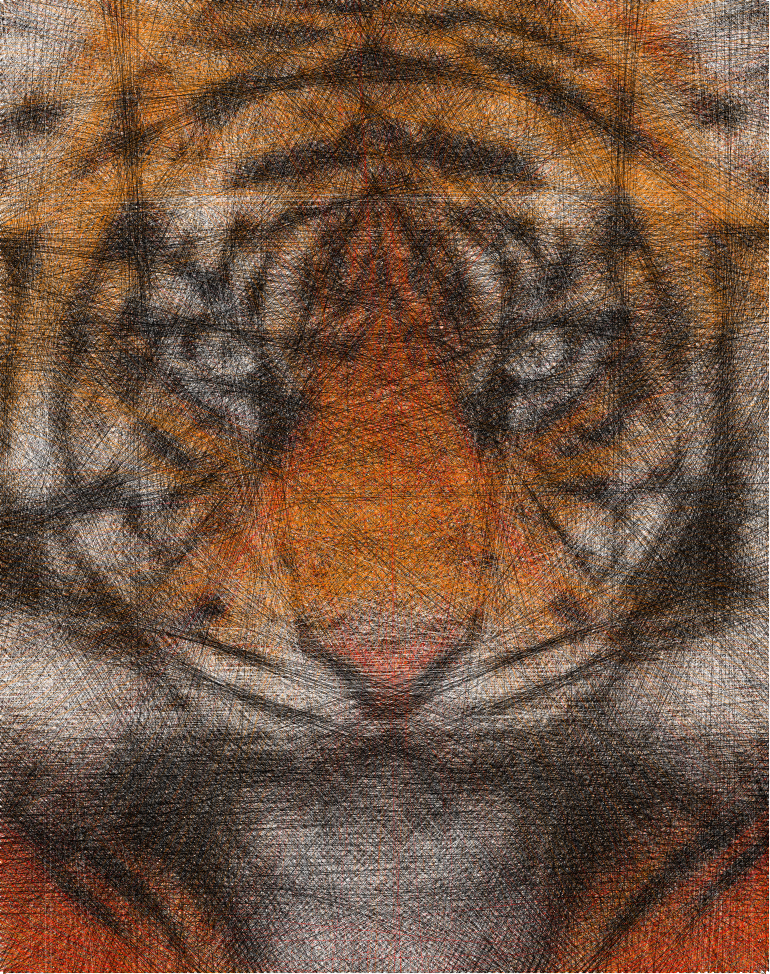

In [ ]:
PARAMS = dict(
    name = "tiger",
    x = 770,
    n_nodes = 500,
    filename = "tiger.jpg",
    w_filename = None,
    palette = dict(
        white = [255, 255, 255],
        orange = [255, 130, 0],
        red = [255, 0, 0],
        black = [0, 0, 0],
    ),
    n_lines_per_color = [4400, 3000, 1000, 7700],
    shape = "Rectangle",
    n_random_lines = 150,
    darkness = 0.16,
    blur_rad = 4,
    group_orders = "worb" * 5,
    line_width_multiplier = 1.1,
)

args = ThreadArtColorParams(**PARAMS)
MyImg = Img(**args.img_dict)
line_dict = create_canvas(MyImg, args)

paint_canvas(line_dict, MyImg, args, mode="svg")

with open('outputs/tiger_01.svg', 'r') as f:
    display(SVG(f.read()))

FS dithering complete in 4.38s
FS dithering (wrapper) complete in 0.03s
Other init operations complete in 5.40 seconds
Color white,  line 1200/1200 done.
Color red,    line  600/600  done.
Color yellow, line 1200/1200 done.
Color black,  line 7800/7800 done.
total time = 101.59
Saving to 'outputs/duck_01.svg'


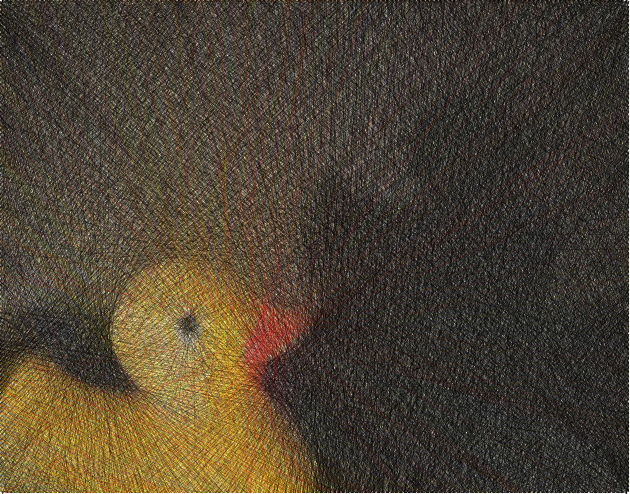

In [ ]:
PARAMS = dict(
    name = "duck",
    x = 630,
    n_nodes = 500,
    filename = "duck.jpg",
    w_filename = "duck_importance_weighting.jpg",
    palette = dict(
        white = [255, 255, 255],
        red = [255, 0, 0],
        yellow = [255, 255, 0],
        black = [0, 0, 0],
    ),
    n_lines_per_color = [1200, 600, 1200, 7800],
    shape = "Rectangle",
    n_random_lines = 150,
    darkness = 0.14,
    blur_rad = 4,
    group_orders = "wrywrybwrybrybrbb",
    line_width_multiplier = 1.1,
)

args = ThreadArtColorParams(**PARAMS)
MyImg = Img(**args.img_dict)
line_dict = create_canvas(MyImg, args)

paint_canvas(line_dict, MyImg, args, mode="svg", show_individual_colors=True)

with open('outputs/duck_01.svg', 'r') as f:
    display(SVG(f.read()))